# **Homework 2 Solutions**

---


Your goal in this homework is to build a regression model of the price of an automobile as a function of many of its attributes, e.g., weight, number of doors, engine location, etc. The data set comes from UCI dataset archive, and is available from this page:

https://archive.ics.uci.edu/ml/datasets/Automobile

***Please read the dataset description page first before any coding. For example, there are some missing values (you need to deal with them on your own, remember how?) in the dataset (marked with '?').***


##  ***Regression in Python***

In [ ]:
# Import the necessary packages

import pandas as pd 
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns 
import statsmodels.formula.api as smf
import statsmodels.api as sm

# File url
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"

# load data
df = pd.read_csv(filename)

# giving names to columns
df.columns = ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']


# preview
df.head()
# to view whole data set
# pd.set_option('display.max_rows', 500)
# display(df)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


### DATA cleaning , dealing with NULL values and typecasting



- Since I can see that some values contain '?'
- First we replace those values and then check for NAN / NUll values and deal with them 

In [ ]:
df.replace('?',np.nan,inplace=True)
Nan_values=df.isna().sum().sort_values(ascending=False)
Nan_values

normalized-losses    40
price                 4
stroke                4
bore                  4
peak-rpm              2
horsepower            2
num-of-doors          2
length                0
make                  0
fuel-type             0
aspiration            0
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
height                0
width                 0
highway-mpg           0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
compression-ratio     0
city-mpg              0
symboling             0
dtype: int64

- For normalized losses i am replacing the null values with their averages 
- for num-of-doors , since i noticed the body-style as sedan for those missing values , and that 4 door cars are more popular / common . I am replacing the missing values with '4'
- the rest of the missing values in the columns, I am simply dropping them

In [ ]:

nl=df['normalized-losses'].astype('float64')
avg_for_norm_losses=nl.mean()
df['normalized-losses'].replace(np.nan,avg_for_norm_losses,inplace=True)
#--------
df['num-of-doors'].replace(np.nan,'four',inplace=True)
df.dropna(subset=['price','stroke','bore','peak-rpm','horsepower'],inplace=True)
Nan_values=df.isna().sum().sort_values(ascending=False)
Nan_values


price                0
highway-mpg          0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
symboling            0
dtype: int64

In [ ]:
df.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [ ]:
df['price'] = df['price'].astype('int')
df['normalized-losses'] = df['normalized-losses'].astype('int')
df['bore'] = df['bore'].astype('float')
df['stroke'] = df['stroke'].astype('float')
df['horsepower'] = df['horsepower'].astype('float')
df['peak-rpm'] = df['peak-rpm'].astype('int')
df.dtypes

symboling              int64
normalized-losses      int64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm               int64
city-mpg               int64
highway-mpg            int64
price                  int64
dtype: object

In [ ]:
# forward selection function

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

## **Q1(a)  Build a model of automobile price.**
## ***Don't include any categorical variables.***

Make sure the model:

- is the best one you can get (based on adjusted R^2),
- has no significant multicolinearity, 
- is not overfit, and
- passes the regression diagnostics.

In [ ]:
# since we do not need categorical variables
df_1=df.select_dtypes(exclude=['object'])
# since having a '-' was giving a error in the forward selection code , we just rename the required variables 
df_1.columns = ['symboling','normalizedlosses','wheelbase','length','width','height','curbweight','engine_size','bore','stroke','compression_ratio','horsepower','peakrpm','city_mpg','highway_mpg','price']
# now we feed it to the forward selection model and print the features selected by it and the adjusted R^2 
model=forward_selected(df_1,'price')
print(model.model.formula)
print(model.rsquared_adj)

price ~ engine_size + width + horsepower + stroke + compression_ratio + peakrpm + height + length + 1
0.8471674650897364


Data analysis using heat maps

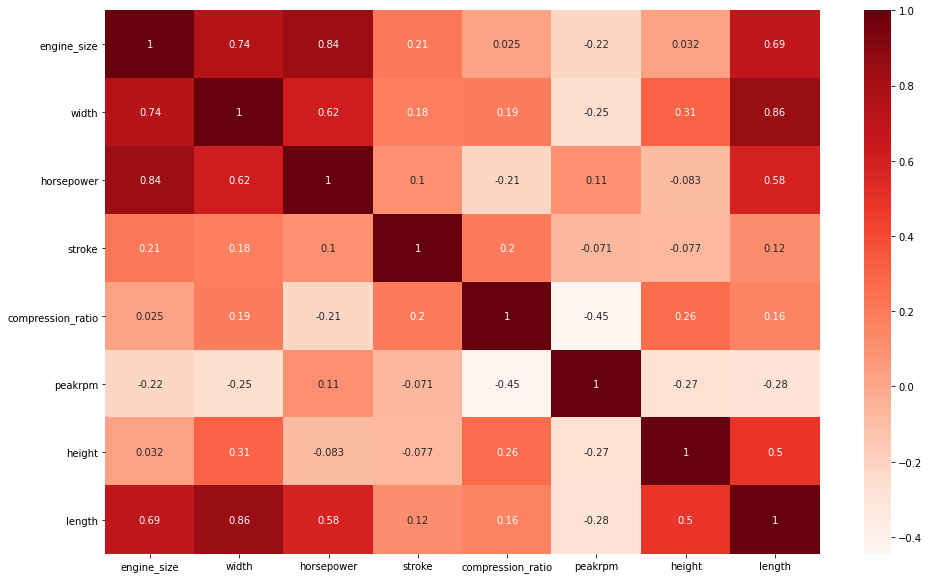

In [ ]:
df_needed=df_1[['engine_size','width','horsepower', 'stroke', 'compression_ratio' , 'peakrpm','height','length']]
plt.figure(figsize=(16,10))
cor = df_needed.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- Since I noticed a high P index / coefficent for a lot of variables, it indicated multi colinearity being present 
- we drop one of those variables 
- also in the preliminary analysis , i noticed that city mpg and highway-mpg are (highly) negatively corelated with price , so including them should give me a better prediction of the variable price 



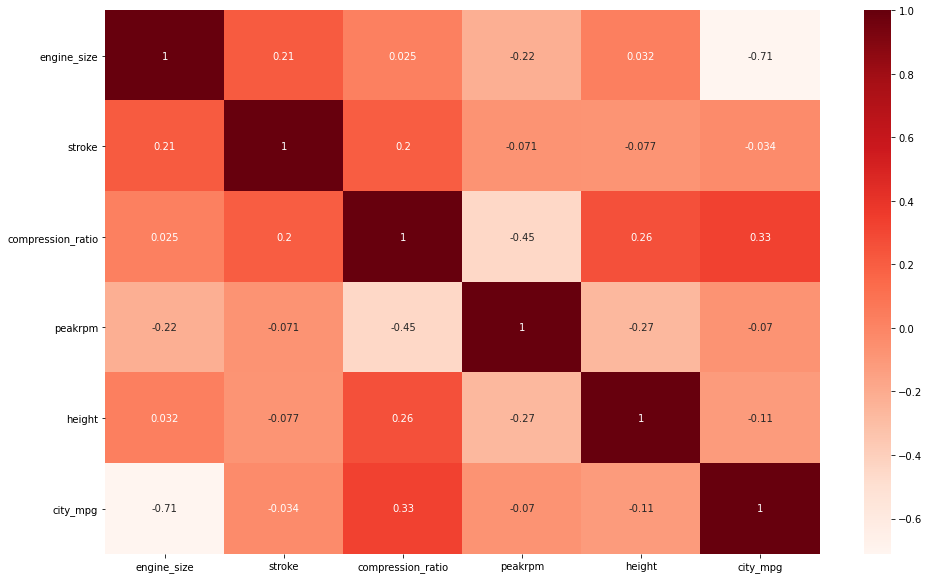

In [ ]:
df_needed=df_1[['engine_size', 'stroke', 'compression_ratio' ,'peakrpm','height','city_mpg']].copy()
plt.figure(figsize=(16,10))
cor = df_needed.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
# in the model we see that there is no significant multi - colinearity , so we proceed to the model building 

### Select the dependent variable, and your independent variables of interest.

In [ ]:
# YOUR CODE
Y = df_1['price']

# YOUR CODE
X = df_1[['engine_size', 'stroke', 'compression_ratio' ,'peakrpm','height','city_mpg']].copy()

##Build Your Model with statsmodels#

In [ ]:
import statsmodels.api as sm

In [ ]:
# create the X matrix by appending a column of ones to X
X = sm.add_constant(X)

Build your models with independent variables X and dependent variable Y

In [ ]:
# YOUR CODE
fitted_model_1 = sm.OLS(endog= Y, exog=X, hasconst=True).fit()

Show the summary of your best model

In [ ]:
# YOUR CODE
print(fitted_model_1.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     167.0
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           2.50e-72
Time:                        07:40:41   Log-Likelihood:                -1840.7
No. Observations:                 194   AIC:                             3695.
Df Residuals:                     187   BIC:                             3718.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.741e+04   8875.61

Show the $R^2$ and adj. $R^2$ of your best model.

In [ ]:
# YOUR CODE
print('The R_squared for this model is :',fitted_model_1.rsquared)
print('The adjusted R_squared for this model is',fitted_model_1.rsquared_adj)

The R_squared for this model is : 0.8427124862760034
The adjusted R_squared for this model is 0.8376658280816506


In [ ]:
# vif calculations
train_transformed=X
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = [variance_inflation_factor(train_transformed.values, i) for i in range(train_transformed.shape[1])]
vif_df

[1443.0178356818644,
 2.857878065318873,
 1.1207524825427795,
 1.7087084744767704,
 1.4239608295333357,
 1.2648075813933184,
 3.094586649298547]

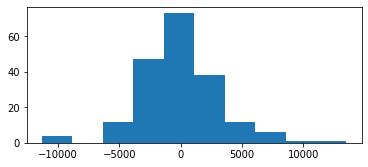

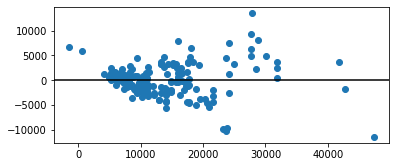

In [ ]:
# diagnostics
pred_val = fitted_model_1 .fittedvalues.copy()
true_val =df['price'].values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(6,2.5))
ax.hist(residual)

fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(pred_val,residual)
plt.axhline(0, color='k')

## Q1a Model Results text
- The adj. R2 of your model: 0.838 (0.8376)
- Number of variables      : Six (6) 
- The VIF values of each variable :[2.857878065318873,
 1.1207524825427795,
 1.7087084744767704,
 1.4239608295333357,
 1.2648075813933184,
 3.094586649298547]
- Diagnostics                : Yes

##**Q1.b Your model from 1a. uses a number of attributes. Here we care about the top 3 most important (variance explained) and significant (p-value) attributes in your model in terms of the variance they explain**


In [ ]:
Y = df_1['price']
d=df_1[['engine_size', 'stroke', 'compression_ratio' ,'peakrpm','height','city_mpg']].copy()
for column in d:
  X=d[column]
  X = sm.add_constant(X)
  fitted_model_1 = sm.OLS(endog= Y, exog=X, hasconst=True).fit()
  # print('---------------------------------------------------------')
  print(column)
  print('R_squared for this feature is :',fitted_model_1.rsquared)
  print('P value for this feature is :',fitted_model_1.f_pvalue)
  print('The adjust R_squared for this feature is',fitted_model_1.rsquared_adj)
  print('---------------------------x-----------------------------')

engine_size
R_squared for this feature is : 0.790218268949013
P value for this feature is : 5.011340860683119e-67
The adjust R_squared for this feature is 0.7891256557664559
---------------------------x-----------------------------
stroke
R_squared for this feature is : 0.008996243425960171
P value for this feature is : 0.18833607896552737
The adjust R_squared for this feature is 0.0038347655271371295
---------------------------x-----------------------------
compression_ratio
R_squared for this feature is : 0.00483896903062897
P value for this feature is : 0.33514475487306583
The adjust R_squared for this feature is -0.00034416133900316837
---------------------------x-----------------------------
peakrpm
R_squared for this feature is : 0.010881014358582464
P value for this feature is : 0.14776761918512987
The adjust R_squared for this feature is 0.005729352975033519
---------------------------x-----------------------------
height
R_squared for this feature is : 0.019671852438341353
P v

### Show the top 3 important variables in your model, and the variance explained by each.

In [ ]:
# from the above code we can understand that the top 3 predictors are :enginesize , city mpg and height
Y = df_1['price']
d=df_1[['engine_size','height','city_mpg']].copy()
for column in d:
  X=d[column]
  X = sm.add_constant(X)
  fitted_model_1 = sm.OLS(endog= Y, exog=X, hasconst=True).fit()
  # print('---------------------------------------------------------')
  print(column)
  print(fitted_model_1.summary())
  print('-------------------------------xxx----------------------------------------------------')
  print('R_squared for this feature is :',fitted_model_1.rsquared)
  print('P value for this feature is :',fitted_model_1.f_pvalue)
  print('The adjust R_squared for this feature is',fitted_model_1.rsquared_adj)
  print('---------------------------x-----------------------------')

engine_size
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     723.2
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           5.01e-67
Time:                        07:40:42   Log-Likelihood:                -1868.7
No. Observations:                 194   AIC:                             3741.
Df Residuals:                     192   BIC:                             3748.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8864.9297    864.257    -

## Q1b. Top 3 predictors in 1a model are:
- variable_1:**engine_size** ,(R2 : 0.790218268949013,p-value : 5.011340860683119e-67)
- variable_2: **city_mpg** , (R2 : 0.4948130395886282
p-value : 2.7647222152939667e-30)
- variable_3: **height** , (R2 :0.019671852438341353
p-value : 0.05110783543430583)

##**Q1.c Interpret the model for those 3 attributes, in words. For each of the 3 top attributes in your model, write one sentence into a text cell, interpreting its effect.**

1st predictor interpretation: engine_size is able to explain 79% of the variance in the target variable price , it also has a low p-value which would mean it is significant in prediction . It also has a narrow confidence interval.Lastly we understand , that its positively corelated to the target variable , so for increase in the engine size we can expect the price to increase by around 172 units 

2nd predictor interpretation:city_mpg is able to explain 49% of the variance in the target variable price , it also has a low p-value which would mean it is significant in prediction . It also has a narrow confidence interval, but not as narrow as engine_size .Lastly we understand , that its negatively corelated to the target variable , so for increase in the city_mpg the price of the car would decrease by 886 units 

3rd predictor interpretation:height is able to explain 1.9% of the variance in the target variable price , it also has a slighly higher p-value which would mean it is less significant in prediction . It also has the widest confidence interval.Lastly we understand , that its positively corelated to the target variable and for increase in the hight of the car we can expect a increase in price 

## **Q2  Build a model of automobile price.**

## ***Include categorical variables.***

Make sure the model:

- is the best one you can get (based on adjusted R^2),
- it has no significant multicolinearity, 
- it is not overfit, and
- passes the regression diagnostics.

In [ ]:
# renaming the columns as '-' gives an error
df.columns = ['symboling','normalized_losses','make','fuel_type','aspiration','num_of_doors','body_style','drive_wheels','engine_location','wheel_base','length','width','height','curb_weight','engine_type','num_of_cylinders','engine_size','fuel_system','bore','stroke','compression_ratio','horsepower','peak_rpm','city_mpg','highway_mpg','price']
df.head()
df.shape

(194, 26)

In [ ]:
# Converion of categorical variables 
# converting num_of_doors
n_doors = {"num_of_doors":{"four": 4, "two": 2}}
# converting num_of_cylinders
n_cyl={'num_of_cylinders':{'four':4,'six':6,'five':5,'eight':8,'twelve':12,'three':3}}
df.replace(n_cyl,inplace=True)
df.replace(n_doors,inplace=True)
# i will dolabel encoding for all other categorical variables
# first we change thier categeroy 
df['body_style'] = df['body_style'].astype('category')
df['make'] = df['make'].astype('category')
df['fuel_type'] = df['fuel_type'].astype('category')
df['aspiration'] = df['aspiration'].astype('category')          
df['drive_wheels'] = df['drive_wheels'].astype('category')   
df['engine_location'] = df['engine_location'].astype('category')           
df['engine_type'] = df['engine_type'].astype('category')   
df['fuel_system'] = df['fuel_system'].astype('category')
#  now we label encode them 
df['body_style'] = df['body_style'].cat.codes
df['make'] = df['make'].cat.codes
df['fuel_type'] = df['fuel_type'].cat.codes
df['aspiration'] = df['aspiration'].cat.codes          
df['drive_wheels'] = df['drive_wheels'].cat.codes   
df['engine_location'] = df['engine_location'].cat.codes           
df['engine_type'] = df['engine_type'].cat.codes   
df['fuel_system'] = df['fuel_system'].cat.codes  
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,122,0,1,0,2,0,2,0,88.6,168.8,64.1,48.8,2548,0,4,130,4,3.47,2.68,9.0,111.0,5000,21,27,16500
1,1,122,0,1,0,2,2,2,0,94.5,171.2,65.5,52.4,2823,4,6,152,4,2.68,3.47,9.0,154.0,5000,19,26,16500
2,2,164,1,1,0,4,3,1,0,99.8,176.6,66.2,54.3,2337,2,4,109,4,3.19,3.40,10.0,102.0,5500,24,30,13950
3,2,164,1,1,0,4,3,0,0,99.4,176.6,66.4,54.3,2824,2,5,136,4,3.19,3.40,8.0,115.0,5500,18,22,17450
4,2,122,1,1,0,2,3,1,0,99.8,177.3,66.3,53.1,2507,2,5,136,4,3.19,3.40,8.5,110.0,5500,19,25,15250


In [ ]:
df.shape
# we can see that the shape is same after label encoding as well., so we havent lost ant columns 

(194, 26)

In [ ]:
# upon feeding it to the forward selection code 
model=forward_selected(df,'price')
print(model.model.formula)
print(model.rsquared_adj)

price ~ engine_size + engine_location + width + make + curb_weight + stroke + engine_type + aspiration + height + peak_rpm + body_style + highway_mpg + fuel_system + symboling + bore + 1
0.8946902011082973


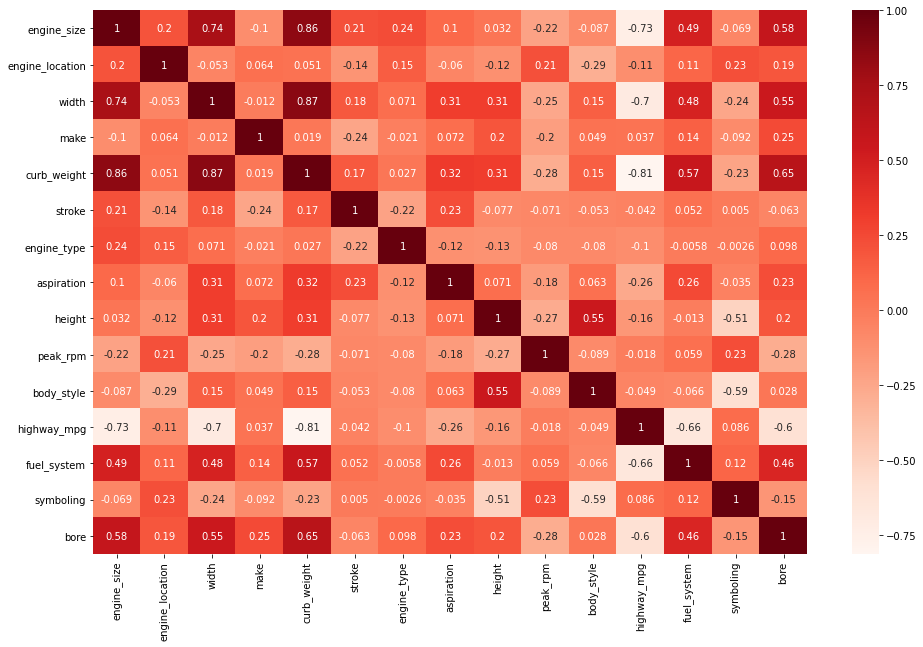

In [ ]:
df_needed=df[['engine_size' ,'engine_location' ,'width' , 'make' , 'curb_weight' ,'stroke' , 'engine_type',  'aspiration' , 'height' ,'peak_rpm' , 'body_style' , 'highway_mpg' , 'fuel_system' ,'symboling' ,'bore']]
d=df_needed.copy()
# plot an initial heat map
plt.figure(figsize=(16,10))
cor = d.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

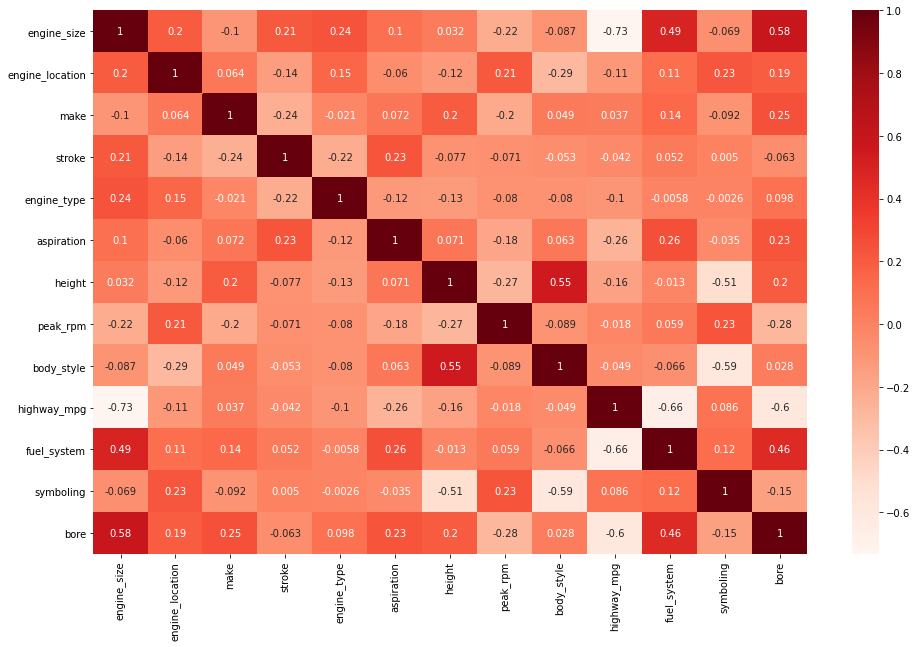

In [ ]:
# we will drop a number of varibales in order to reudce multi - colinearity 
d=df[['engine_size' ,'engine_location' , 'make' ,'stroke' , 'engine_type',  'aspiration' , 'height' ,'peak_rpm' , 'body_style' , 'highway_mpg' , 'fuel_system' ,'symboling' ,'bore']].copy()
# now we will plot the heat map again
plt.figure(figsize=(16,10))
cor = d.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Select the dependent variable, and your independent variables of interest.

In [ ]:
# YOUR CODE
Y = df['price']

# YOUR CODE
# we drop bore from the above as I noticed that it had high p-value
X =df[['engine_size' ,'engine_location' , 'make' ,'stroke' , 'engine_type',  'aspiration' , 'height' ,'peak_rpm' , 'body_style' , 'highway_mpg' , 'fuel_system' ,'symboling']]

##Build Your Model with statsmodels#

In [ ]:
# create the X matrix by appending a column of ones to X
X = sm.add_constant(X)

Build your models with independent variables X and dependent variable Y

In [ ]:
# YOUR CODE
fitted_model_1 = sm.OLS(endog= Y, exog=X, hasconst=True).fit()

Show the summary of your best model.

In [ ]:
# YOUR CODE
print(fitted_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     118.4
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           6.56e-79
Time:                        07:40:48   Log-Likelihood:                -1808.6
No. Observations:                 194   AIC:                             3643.
Df Residuals:                     181   BIC:                             3686.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.404e+04   8920.908     

Show the $R^2$ and adj. $R^2$ of your best model.

In [ ]:
# YOUR CODE
print('The R_squared for this model is :',fitted_model_1.rsquared)
print('The adjusted R_squared for this model is',fitted_model_1.rsquared_adj)


The R_squared for this model is : 0.8870111054038446
The adjusted R_squared for this model is 0.8795201289665304


In [ ]:
train_transformed=X
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = [variance_inflation_factor(train_transformed.values, i) for i in range(train_transformed.shape[1])]
vif_df

[1964.212822156288,
 3.662726896356402,
 1.3497922578198684,
 1.2864088291208768,
 1.420673566786686,
 1.2486755479208063,
 1.3215634246311505,
 1.8524217367734495,
 1.6334409244490795,
 1.9338026062139475,
 3.9233262545922556,
 2.119428554669521,
 1.7969526908583935]

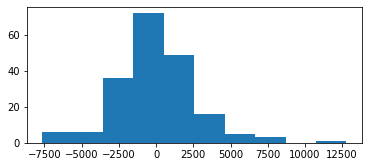

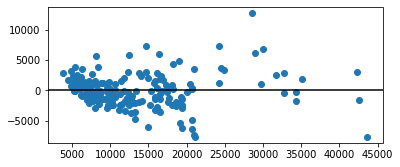

In [ ]:
# diagnostics
pred_val = fitted_model_1 .fittedvalues.copy()
true_val =df['price'].values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(6,2.5))
ax.hist(residual)

fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(pred_val,residual)
plt.axhline(0, color='k')

## Q2 Model Results text
- The adj. R2 of your model: 0.880 (0.8809978019525292)
- Number of variables      : Twelve(12)
- The VIF values of each variable :[3.662726896356402,
 1.3497922578198684,
 1.2864088291208768,
 1.420673566786686,
 1.2486755479208063,
 1.3215634246311505,
 1.8524217367734495,
 1.6334409244490795,
 1.9338026062139475,
 3.9233262545922556,
 2.119428554669521,
 1.7969526908583935]
- Diagnostics                : Yes

## **Q3  Can you find a better model (i.e., higher R^2 adjusted) using polynomial regression?**


Make sure the model:

- is the best one you can get (based on adjusted R^2),
- has no significant multicolinearity, 
- is not overfit, and
- passes the regression diagnostics.

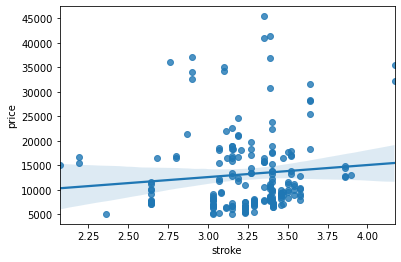

In [ ]:
# I will attempt to use regplot to understand which variable(s)/features(s) could be included as a higher order polynomial (terms)
sns.regplot(x="stroke", y="price", data=df)

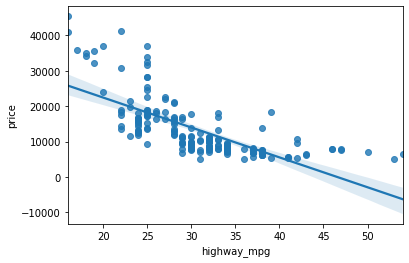

In [ ]:
sns.regplot(x="highway_mpg", y="price", data=df)

### Select the dependent variable, and your independent variables of interest.

In [ ]:
# YOUR CODE
Y = df['price']

# YOUR CODE
# we drop bore from the above as I noticed that it had high p-value
X =df[['engine_size' ,'engine_location' , 'make' ,'stroke' , 'engine_type',  'aspiration' , 'height' ,'peak_rpm' , 'body_style' , 'highway_mpg' , 'fuel_system' ,'symboling']]
X['stroke'] = df['stroke']**3
X['highway_mpg'] = df['highway_mpg']**2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##Build Your Model with statsmodels#

In [ ]:
# import statsmodels.api as sm

In [ ]:
# create the X matrix by appending a column of ones to X
X = sm.add_constant(X)

Build your models with independent variables X and dependent variable Y

In [ ]:
# YOUR CODE
fitted_model_1 = sm.OLS(endog= Y, exog=X, hasconst=True).fit()

Show the summary of your best model

In [ ]:
# YOUR CODE
print(fitted_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     120.1
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           2.16e-79
Time:                        07:40:49   Log-Likelihood:                -1807.4
No. Observations:                 194   AIC:                             3641.
Df Residuals:                     181   BIC:                             3683.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -3.9e+04   7955.316     

Show the $R^2$ and adj. $R^2$ of your best model.

In [ ]:
# YOUR CODE
print('The R_squared for this model is :',fitted_model_1.rsquared)


The R_squared for this model is : 0.8883969023492632


In [ ]:
# YOUR CODE
print('The adjusted R_squared for this model is',fitted_model_1.rsquared_adj)

The adjusted R_squared for this model is 0.8809978019525292


In [ ]:
#VIF check without polynomial terms 
train_transformed=X
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = [variance_inflation_factor(train_transformed.values, i) for i in range(train_transformed.shape[1])]
vif_df

[1581.4110275842465,
 2.9602672740850746,
 1.336793908613686,
 1.281820383215444,
 1.4574712246681363,
 1.283938065957799,
 1.2890454724075016,
 1.8312903803585203,
 1.5846539950281433,
 1.9303891851607888,
 2.823594585928721,
 2.0390036749898983,
 1.7990848095252405]

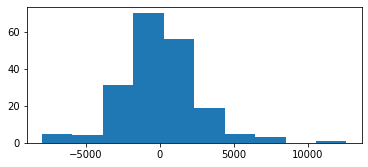

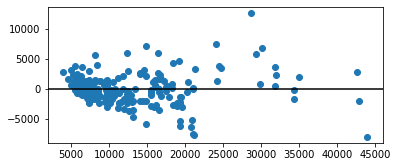

In [ ]:
# diagnostics
pred_val = fitted_model_1 .fittedvalues.copy()
true_val =df['price'].values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(6,2.5))
ax.hist(residual)

fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(pred_val,residual)
plt.axhline(0, color='k')

## Q2 Model Results text
- The adj. R2 of your model: 0.881 (0.8809)
- Number of variables      : Twelve(12)
- The VIF values of each variable :[2.9602672740850746,
 1.336793908613686,
 1.281820383215444,
 1.4574712246681363,
 1.283938065957799,
 1.2890454724075016,
 1.8312903803585203,
 1.5846539950281433,
 1.9303891851607888,
 2.823594585928721,
 2.0390036749898983,
 1.7990848095252405]
- Diagnostics                : Yes

###**Good Job! You are done here!**